In [2]:
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n

import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras import models
from keras import layers
from keras.preprocessing import text, sequence
from keras import utils

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from urllib.parse import urlparse

You have TensorFlow version 1.14.0


Using TensorFlow backend.


In [3]:
print(os.getcwd())

C:\Users\eanusau\Documents\AI\Stat\Projects\drivebuddyAI


In [50]:
original_pavbhaji_dataset_dir = r'C:\Users\eanusau\Documents\AI\Stat\Projects\drivebuddyAI\machinelearningchallenge-master\dataset\1'
original_non_pavbhaji_dataset_dir = r'C:\Users\eanusau\Documents\AI\Stat\Projects\drivebuddyAI\machinelearningchallenge-master\dataset\0'

In [51]:
data = pd.read_json(r'C:\Users\eanusau\Documents\AI\Stat\Projects\drivebuddyAI\machinelearningchallenge-master\dataset\pavbhaji.json')

In [52]:
data.shape

(1500, 18)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
dimensions                 1500 non-null object
display_url                1500 non-null object
edge_liked_by              1500 non-null object
edge_media_preview_like    1500 non-null object
edge_media_to_caption      1500 non-null object
edge_media_to_comment      1500 non-null object
id                         1500 non-null int64
is_video                   1500 non-null bool
location                   924 non-null object
owner                      1500 non-null object
shortcode                  1500 non-null object
tags                       1499 non-null object
taken_at_timestamp         1500 non-null int64
thumbnail_resources        1500 non-null object
thumbnail_src              1500 non-null object
urls                       1500 non-null object
video_view_count           110 non-null float64
comments_disabled          1491 non-null float64
dtypes: bool(1), float64(2), int6

In [54]:
data.tags

0       [vadapav, foodgram, foodphotography, foodblogg...
1       [healthyfood, sokolkata, mumbaifoodie, faridab...
2       [foodphotography, mumbaipeople, vascom, delhib...
3       [foodvideo, misscravingbuster, foodblogger, mu...
4                                                      []
                              ...                        
1495    [foodphotography, bhaji, pasta, fries, indianf...
1496    [cravings, foodcoma, mumbaifoodie, dailyfoodfe...
1497    [mumbaistreetfood, whaaatislife, foodblogger, ...
1498    [mumbaifoodlovers, likeforfollow, hungry, mumb...
1499    [â�¤, foodphotography, streetcravings, foodblo...
Name: tags, Length: 1500, dtype: object

### Preprocessing the data

In [55]:
nlp = spacy.load('en_core_web_sm')

# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

def text_preprocessing(text, accented_chars=True, contractions=False, 
                       convert_num=True, extra_whitespace=True,
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [56]:
def remove_tags(tags):
    """remove tags from text"""
    text=[]
    stopwords = ['edge','node','text']
    resultwords  = [word for word in tags if word.lower() not in stopwords]
    text = ' '.join(resultwords)
    return text

In [57]:
print(data.isnull().sum())
data['tags'].fillna('pavbhaji', inplace=True)
#data = data.drop([512], axis=0)

dimensions                    0
display_url                   0
edge_liked_by                 0
edge_media_preview_like       0
edge_media_to_caption         0
edge_media_to_comment         0
id                            0
is_video                      0
location                    576
owner                         0
shortcode                     0
tags                          1
taken_at_timestamp            0
thumbnail_resources           0
thumbnail_src                 0
urls                          0
video_view_count           1390
comments_disabled             9
dtype: int64


In [58]:
data['tags'] =data.apply(lambda x: text_preprocessing(str(x['tags'])),axis=1)

In [59]:
data.head()

,dimensions,display_url,edge_liked_by,edge_media_preview_like,edge_media_to_caption,edge_media_to_comment,id,is_video,location,owner,shortcode,tags,taken_at_timestamp,thumbnail_resources,thumbnail_src,urls,video_view_count,comments_disabled
0,"{'height': 734, 'width': 640}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/352...,{'count': 3797},{'count': 3797},{'edges': [{'node': {'text': 'TAG A PAV BHAJI ...,{'count': 52},1834712933156555776,True,None,{'id': '1919686029'},Bl2NbElnIva,"[vadapav, foodgram, foodphotography, foodblogg...",1532934873,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/cb5...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/89...,0.0,NaN
1,"{'height': 750, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/b0d...,{'count': 12041},{'count': 12041},{'edges': [{'node': {'text': 'à¤¦à¥‡à¤¸à¥€ à¤¸...,{'count': 325},1826000656302706176,True,"{'has_public_page': True, 'id': '245717485', '...",{'id': '1445587278'},BlXQewejY3Z,"[healthyfood, sokolkata, mumbaifoodie, faridab...",1531897016,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/ad3...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/9c...,0.0,NaN
2,"{'height': 800, 'width': 640}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/cb4...,{'count': 3544},{'count': 3544},{'edges': [{'node': {'text': 'Pav BhajiðŸ˜�ðŸ˜...,{'count': 18},1849962218902145792,True,"{'has_public_page': True, 'id': '213724095', '...",{'id': '4759392841'},BmsYtYpjkq4,"[foodphotography, mumbaipeople, vascom, delhib...",1534752790,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/64f...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/5e...,0.0,NaN
3,"{'height': 937, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/180...,{'count': 1388},{'count': 1388},{'edges': [{'node': {'text': 'Asli Makhan Pav ...,{'count': 91},1828963273137213696,True,"{'has_public_page': True, 'id': '234730336', '...",{'id': '4628040416'},BlhyGgalFDw,"[foodvideo, misscravingbuster, foodblogger, mu...",1532249632,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/802...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/33...,0.0,NaN
4,"{'height': 936, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/5ee...,{'count': 223},{'count': 223},{'edges': [{'node': {'text': 'Tag a Pav bhaji ...,{'count': 14},1852265507774756864,True,None,{'id': '7798081590'},Bm0kapkn3ha,[],1535027282,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/292...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/6a...,0.0,NaN


In [60]:
data.tags

0       [vadapav, foodgram, foodphotography, foodblogg...
1       [healthyfood, sokolkata, mumbaifoodie, faridab...
2       [foodphotography, mumbaipeople, vascom, delhib...
3       [foodvideo, misscravingbuster, foodblogger, mu...
4                                                      []
                              ...                        
1495    [foodphotography, bhaji, pasta, fry, indianfoo...
1496    [craving, foodcoma, mumbaifoodie, dailyfoodfee...
1497    [mumbaistreetfood, whaaatislife, foodblogger, ...
1498    [mumbaifoodlover, likeforfollow, hungry, mumba...
1499    [', a$, foodphotography, streetcraving, foodbl...
Name: tags, Length: 1500, dtype: object

In [61]:
def get_image(url):
    image = urlparse(url).path.split('/')[-1]
    return image

In [62]:
data['image'] = data.apply(lambda x: get_image(x['display_url']),axis=1)

In [63]:
from pathlib import Path
def set_target(image):
    target=0
    if Path(original_pavbhaji_dataset_dir+'/'+image).is_file():
        return 1
    else:
        return 0

In [65]:
data['target'] = data.apply(lambda x: set_target(x['image']),axis=1)

In [66]:
data['target'].value_counts()

0    1317
1     183
Name: target, dtype: int64

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
dimensions                 1500 non-null object
display_url                1500 non-null object
edge_liked_by              1500 non-null object
edge_media_preview_like    1500 non-null object
edge_media_to_caption      1500 non-null object
edge_media_to_comment      1500 non-null object
id                         1500 non-null int64
is_video                   1500 non-null bool
location                   924 non-null object
owner                      1500 non-null object
shortcode                  1500 non-null object
tags                       1500 non-null object
taken_at_timestamp         1500 non-null int64
thumbnail_resources        1500 non-null object
thumbnail_src              1500 non-null object
urls                       1500 non-null object
video_view_count           110 non-null float64
comments_disabled          1491 non-null float64
image                      1500 n

###  Splitting the data into train and test data

In [76]:
X = data['tags']
y = data['target']

# setting up testing and training sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(x_train) # only fit on train
x_train = tokenize.texts_to_matrix(x_train, mode='tfidf')
x_test = tokenize.texts_to_matrix(x_test, mode='tfidf')


In [77]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('X shape:', X.shape)
print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X shape: (1500,)
X_train shape: (1350, 1000)
X_test shape: (150, 1000)
y_train shape: (1350,)
y_test shape: (150,)


### Using SMOTE as the data is unbalanced

In [78]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=0, sampling_strategy='minority')
X_resampled, y_resampled = sm.fit_sample(x_train, y_train)

# setting up testing and training sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.10)

In [79]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_val.shape)

x_train shape: (2136, 1000)
x_test shape: (238, 1000)
y_train shape: (2136,)
y_test shape: (238,)


# Model building

In [80]:
batch_size = 16
epochs = 10 # starts overfitting after 4
from keras import regularizers

# Build the model
model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(max_words,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [81]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Train on 2136 samples, validate on 238 samples
Epoch 1/10
2136/2136 [==============================] - 3s 1ms/step - loss: 1.0033 - acc: 0.7711 - val_loss: 0.7266 - val_acc: 0.8697
Epoch 2/10
2136/2136 [==============================] - 2s 1ms/step - loss: 0.5932 - acc: 0.8816 - val_loss: 0.4985 - val_acc: 0.9034 0s - loss: 0.5985 - ac
Epoch 3/10
2136/2136 [==============================] - 2s 1ms/step - loss: 0.4180 - acc: 0.9148 - val_loss: 0.4557 - val_acc: 0.8950
Epoch 4/10
2136/2136 [==============================] - 2s 955us/step - loss: 0.3527 - acc: 0.9223 - val_loss: 0.3602 - val_acc: 0.9118
Epoch 5/10
2136/2136 [==============================] - 2s 944us/step - loss: 0.3106 - acc: 0.9284 - val_loss: 0.3565 - val_acc: 0.9370
Epoch 6/10
2136/2136 [==============================] - 2s 942us/step - loss: 0.2865 - acc: 0.9270 - val_loss: 0.3902 - val_acc: 0.9118
Epoch 7/10
2136/2136 [==============================] - 2s 970us/step - loss: 0.2693 - acc: 0.9387 - val_loss: 0.2937 - 

### saving the model

In [82]:
import h5py
model.save('pavbhaji.h5')

In [83]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

150/150 [==============================] - 0s 223us/step
Test score: 0.9700731468200684
Test accuracy: 0.793333334128062


### This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%.

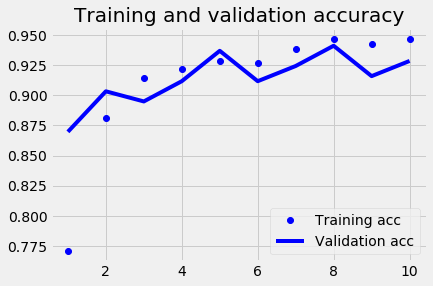

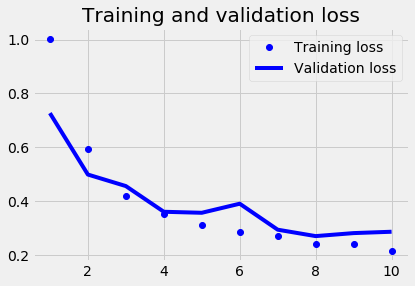

In [84]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [99]:
y_pred = model.predict(x_test)

In [100]:
y_pred = ( y_pred > 0.1)
np.unique(y_pred, return_counts=True)

(array([False,  True]), array([112,  38], dtype=int64))

In [101]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

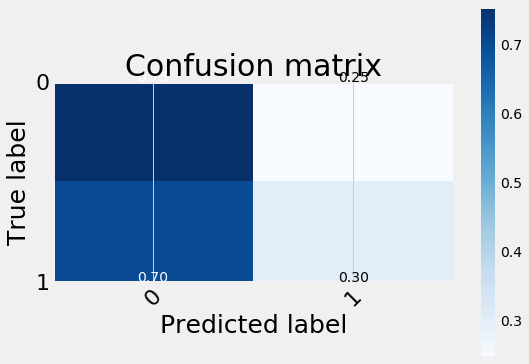

In [102]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()